In [1]:
import os
import re
from diffsky.experimental.disk_bulge_modeling.generate_bulge_disk_sample import (
    get_bulge_disk_test_sample,
    get_bulge_disk_decomposition,
)
from diffaux.validation.plot_utilities import get_zindexes
# or from lsstdesc_diffsky.disk_bulge_modeling.

from jax import random as jran
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import copy
from collections import OrderedDict, namedtuple
from itertools import zip_longest
from diffaux.validation.plot_disk_bulge import (
    plot_q_with_cuts,
    plot_q1_vs_q2,
    plot_q1_q2,
    plot_qs_profiles_with_cuts,
)
from diffaux.validation.plot_utilities import get_nrow_ncol

ran_key = jran.key(0)

In [2]:
halo_key, ran_key = jran.split(ran_key, 2)
lgmp_min = 10.5
redshift = 0.05
Lbox = 100.0
diffstar_cens = get_bulge_disk_test_sample(halo_key, lgmp_min=lgmp_min, redshift=redshift, Lbox=Lbox)
print(list(diffstar_cens.keys()))

Generated data shape =  (43799, 100)
['subcat', 't_table', 't_obs', 'sfh', 'smh', 'mc_quenched', 'sfh_params', 'logsm_obs', 'logssfr_obs', 'sfh_ms', 'sfh_q', 'frac_q', 'sfh_params_ms', 'sfh_params_q', 'sSFR', 'z_table']


In [3]:
zvalues = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
redshifts = diffstar_cens["z_table"]
zindexes, zs = get_zindexes(zvalues, redshifts)
print(len(redshifts))

100


## Tinker with Fbulge Sigmoid Parameters

In [32]:
from diffsky.experimental.disk_bulge_modeling.mc_disk_bulge import DEFAULT_FBULGE_2dSIGMOID_PARAMS
print(DEFAULT_FBULGE_2dSIGMOID_PARAMS)
diffstar_old = copy.deepcopy(diffstar_cens)
diffstar_old = get_bulge_disk_decomposition(
    diffstar_old,
    fbulge_2d_params=DEFAULT_FBULGE_2dSIGMOID_PARAMS,
)

Fbulge2dParams(early_logsm0_x0=10.0, early_logssfr0_x0=-10.0, early_logssfr0_k=0.2, early_logsm0_k=0.2, early_zmin=1.0, early_zmax=0.2, late_logsm0_x0=10.0, late_logssfr0_x0=-10.0, late_logssfr0_k=0.2, late_logsm0_k=0.2, late_zmax=0.1, tcrit_logsm0_x0=10.0, tcrit_logssfr0_x0=-10.0, tcrit_logssfr0_k=0.5, tcrit_logsm0_k=0.8)


In [33]:
fbulge_1=DEFAULT_FBULGE_2dSIGMOID_PARAMS._replace(early_zmax=0.2)
fbulge_2=fbulge_1._replace(early_logsm0_x0=10.5)
fbulge_3=fbulge_2._replace(early_logssfr0_x0=-10.5)
fbulge_4=fbulge_3._replace(early_logssfr0_k=0.8)
fbulge_5=fbulge_4._replace(early_logsm0_k=0.6)
fbulge_6=fbulge_5._replace(early_zmin=0.9)
fbulge_7=fbulge_6._replace(late_zmax=0.0)
fbulge_8=fbulge_7._replace(late_logsm0_x0=10.5)
fbulge_9=fbulge_8._replace(late_logssfr0_x0=-10.5)
fbulge_10=fbulge_9._replace(late_logssfr0_k=0.5)
fbulge_new=fbulge_10._replace(late_logsm0_k=0.4)
print(fbulge_new)
diffstar_new = copy.deepcopy(diffstar_cens)
diffstar_new = get_bulge_disk_decomposition(
    diffstar_new,
    fbulge_2d_params=fbulge_new,
)

Fbulge2dParams(early_logsm0_x0=10.5, early_logssfr0_x0=-10.5, early_logssfr0_k=0.8, early_logsm0_k=0.6, early_zmin=0.9, early_zmax=0.2, late_logsm0_x0=10.5, late_logssfr0_x0=-10.5, late_logssfr0_k=0.5, late_logsm0_k=0.4, late_zmax=0.0, tcrit_logsm0_x0=10.0, tcrit_logssfr0_x0=-10.0, tcrit_logssfr0_k=0.5, tcrit_logsm0_k=0.8)


In [34]:
for k in ["bth", 'logsm_obs', 'logssfr_obs', "fbulge_tcrit", "fbulge_early", "fbulge_late"]:
    print(k, np.min(diffstar_old[k]), np.max(diffstar_old[k]), np.min(diffstar_new[k]), np.max(diffstar_new[k]))

bth 0.3241949904404393 0.926344975968204 0.11374494082071097 0.9477001305921633
logsm_obs 7.930879361576975 12.52254254364516 7.930879361576975 12.52254254364516
logssfr_obs -16.98590338505985 -9.468164331773778 -16.98590338505985 -9.468164331773778
fbulge_tcrit 0.39205901672480464 12.143732290246465 0.39205901672480464 12.143732290246465
fbulge_early 0.5230021131380781 0.8794061723455163 0.29234399075803924 0.8981169512641972
fbulge_late 0.2707882205068395 0.7619167053196714 0.06576678872568228 0.8769113961099296


## Fbulge and B/T Comparisons

In [35]:
plotdir = "/Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots"

0.0 42238
0.5 22376
1.0 4467
1.5 973
2.0 248
2.5 35
Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulge_Histograms/BT_cut_on_log_sSFR_for_Bulge_model_compare_tuning.png
0.0 693418
0.5 878299
1.0 517054
1.5 304545
2.0 218390
2.5 131261
Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulge_Histograms/BT_cut_on_log_sSFR_for_Disk_model_compare_tuning.png


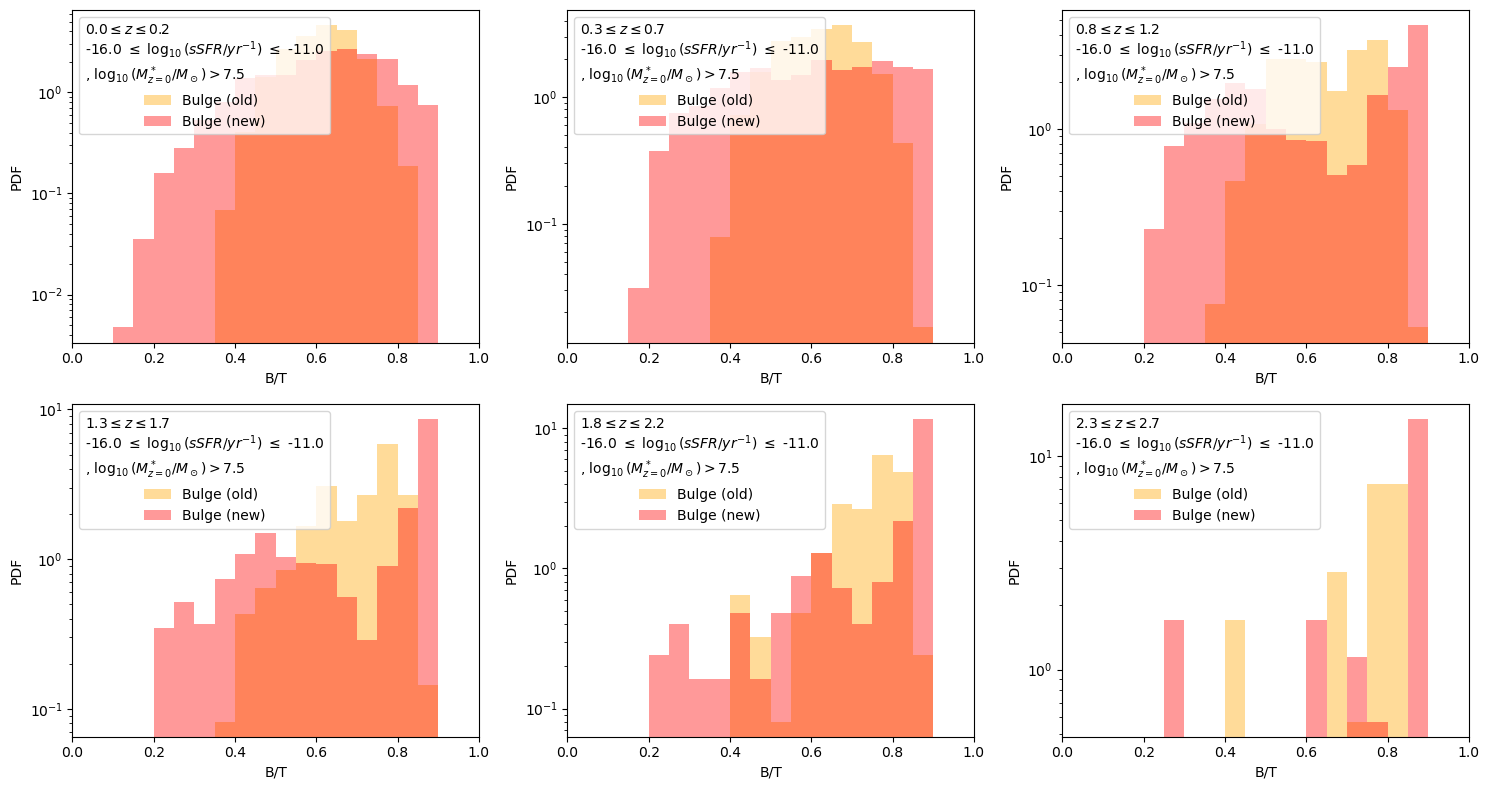

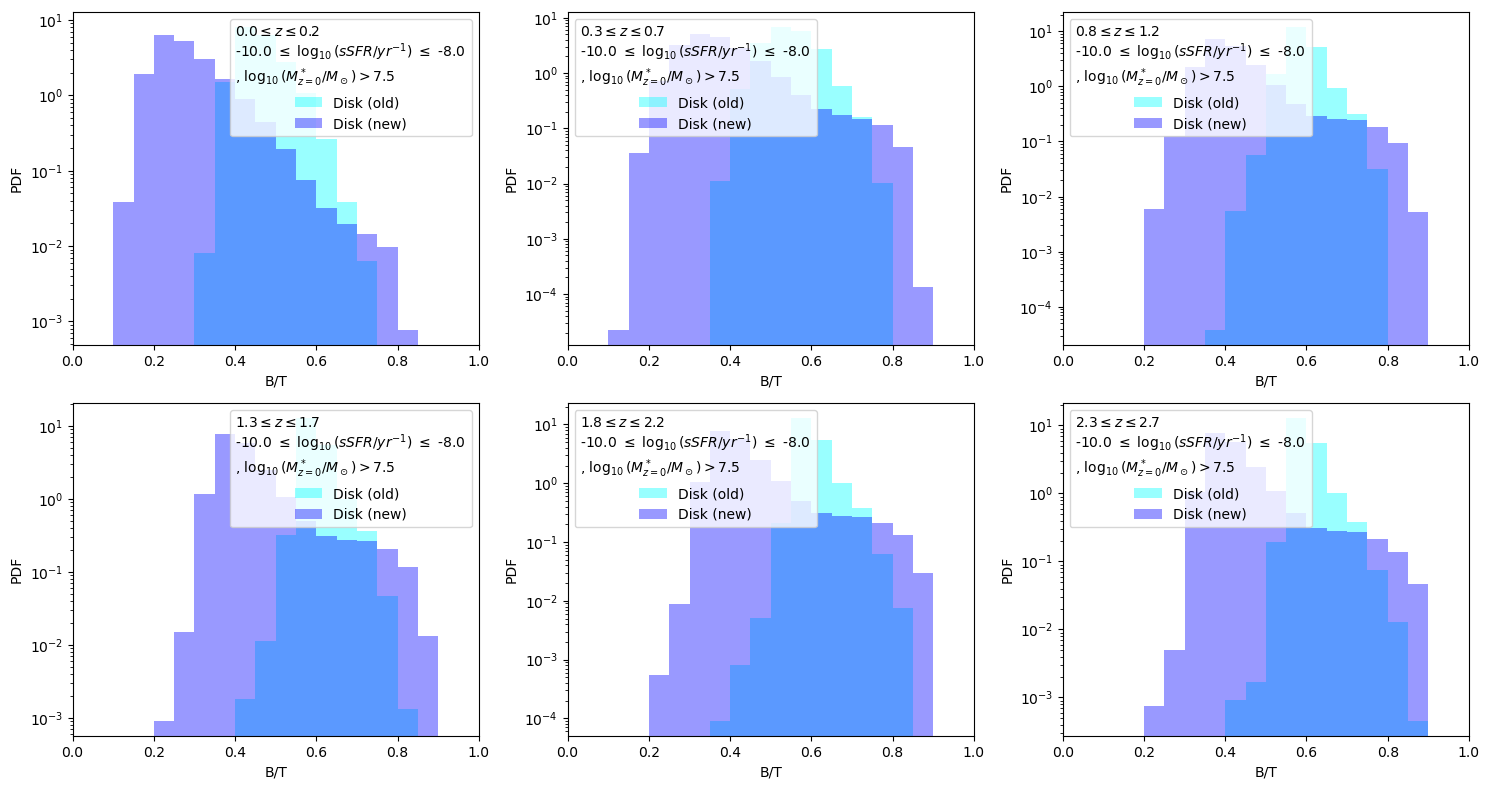

In [36]:
# setup mass mask
logMz0_min = 7.5
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
lgnd_title = ", $\\log_{{10}}(M^*_{{z=0}}/M_\\odot) > {:.1f}$".format(logMz0_min)
versions = ["(old)", "(new)"]
BT_bins = np.linspace(0., 1.0, 21)

sfr_cuts_lo = [-16, -10]
sfr_cuts_hi = [-11, -8]

for sfr_lo, sfr_hi, label, colors in zip(sfr_cuts_lo, sfr_cuts_hi,
                                         ["Bulge {}", "Disk {}"],
                                [['orange', 'r'], ['cyan', 'blue']]):
    qlabels = [label.format(v) for v in versions]
    plot_q1_q2(
        diffstar_old["bth"][mass_mask],
        diffstar_new["bth"][mass_mask],
        zvalues,
        redshifts,
        jnp.log10(diffstar_old["sSFR"])[mass_mask],
        sfr_lo, sfr_hi,
        dz=0.2,
        lgnd_title=lgnd_title,
        plotdir=plotdir,
        xname="log_sSFR_for_{}_model_compare_tuning".format(re.split(' ', label)[0]),
        xlabel="B/T",
        cut_name="$\\log_{10}(sSFR/yr^{-1})$",
        pltname="BT_cut_on_{}.png",
        qlabels=qlabels,
        cut_at_z0=False,
        colors=colors,
        xscale='linear',
        bins=BT_bins,
        xlimits=(0.0, 1.0),
)

## sSFR vs M*colored by B/T

Selected 2010 objects
8.147576129315123 12.123608226848956 -14.665575450630666 -9.702546509031428
Selected 2032 objects
8.07360485597526 12.183644503903357 -15.342777593939461 -9.411288154855068
Selected 1937 objects
7.65750236467816 11.732660327008391 -13.564072167180711 -9.136487087637544
Selected 1929 objects
7.272179886406837 11.928365159141551 -13.604879083846608 -8.948075490913173
Selected 1964 objects
6.623425234840235 11.80399315342446 -12.381535629815554 -8.78706528232839
Selected 2074 objects
6.483960110587753 11.6860434269005 -11.416365170069087 -8.602827695198897
Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulge_Scatter/sSFR_vs_Mstar_log_M0_min_8.0_logssfr_min_14_model_tweak_old.png
Selected 2033 objects
8.171506460660604 12.192093219466486 -16.933901377507294 -9.733811341512308
Selected 1917 objects
8.19838651485406 12.19131342981911 -15.267070182527995 -9.398896385771561
Selected 1924 objects
7.478289096880455 11.914697772346287 -13.851484715779987 -9.0949

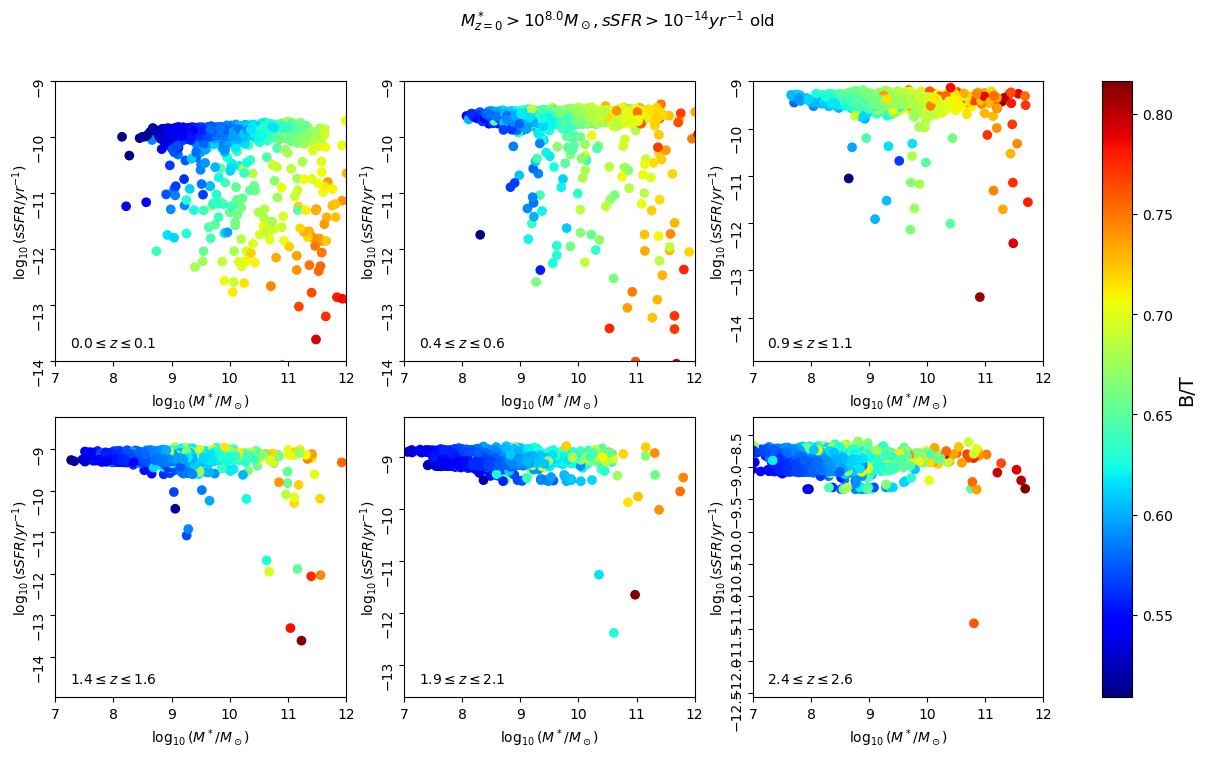

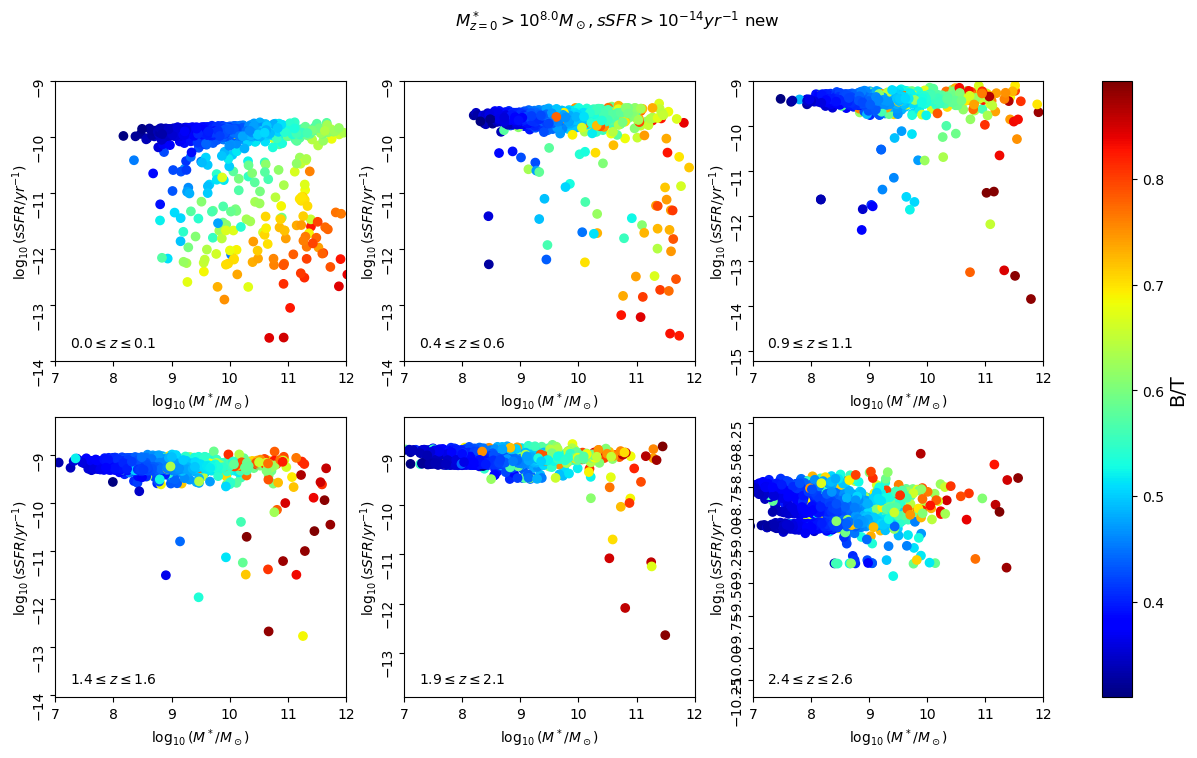

In [37]:
logMz0_min = 8.0
logssfr_min = -14
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
title = "$M^*_{{z=0}} > 10^{{{:.1f}}} M_\\odot, sSFR > 10^{{{}}} yr^{{-1}}$".format(logMz0_min, logssfr_min)
xname = "log_M0_min_{:.1f}_logssfr_min_{}".format(logMz0_min, -logssfr_min)

for diffstar, v in zip([diffstar_old, diffstar_new], ["old", "new"]):
    plot_q1_vs_q2(
        jnp.log10(diffstar["smh"][mass_mask]),
        jnp.log10(diffstar["sSFR"][mass_mask]),
        zvalues,
        redshifts,
        diffstar["bth"][mass_mask],
        title=' '.join([title, v]),
        xname=xname + "_model_tweak_{}".format(v),
        ymin=logssfr_min,
        N=2000,
        plotdir=plotdir,
)

## B/T as a function of M* for SF and Q galaxies

In [38]:
logMz0_min = 8.0
logssfr_min = -15
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
sfr_mask = np.log10(diffstar_cens["sSFR"][:, -1]) > logssfr_min
mask = mass_mask & sfr_mask
title = "$M^*_{{z=0}} > 10^{{{:.1f}}} M_\\odot, sSFR > 10^{{{}}} yr^{{-1}}$".format(logMz0_min, logssfr_min)
xname = "log_M0_min_{:.1f}_logssfr_min_{}".format(logMz0_min, -logssfr_min)

Selected 2090 objects
8.21827195780412 12.147122983728243 0.35647894968746535 0.7960776807902346
Selected 1952 objects
8.060543060851534 12.183542651122549 0.38567941487623664 0.802926368231685
Selected 2061 objects
7.215089650552246 11.743384113208048 0.4647499729967136 0.7849802652015714
Selected 2012 objects
7.404634650716895 11.77328600986987 0.5054827310770842 0.7920877933484409
Selected 2013 objects
6.891006194544497 11.85243616044206 0.5182541938374152 0.8131840852431929
Selected 1965 objects
6.37220948323821 11.507406063641056 0.539133543476382 0.7932677766077869
Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulge_Scatter/BoverT_vs_logMstar_log_M0_min_8.0_logssfr_min_15_model_tweak_old.png
Selected 1944 objects
8.099082029946505 12.471316332396963 0.13905338091061578 0.869678533628423
Selected 1942 objects
7.992234099745222 12.004271104154178 0.185208511230829 0.8623990294066302
Selected 2070 objects
7.606706005786389 11.932010712376691 0.284216781430647 0.8768105

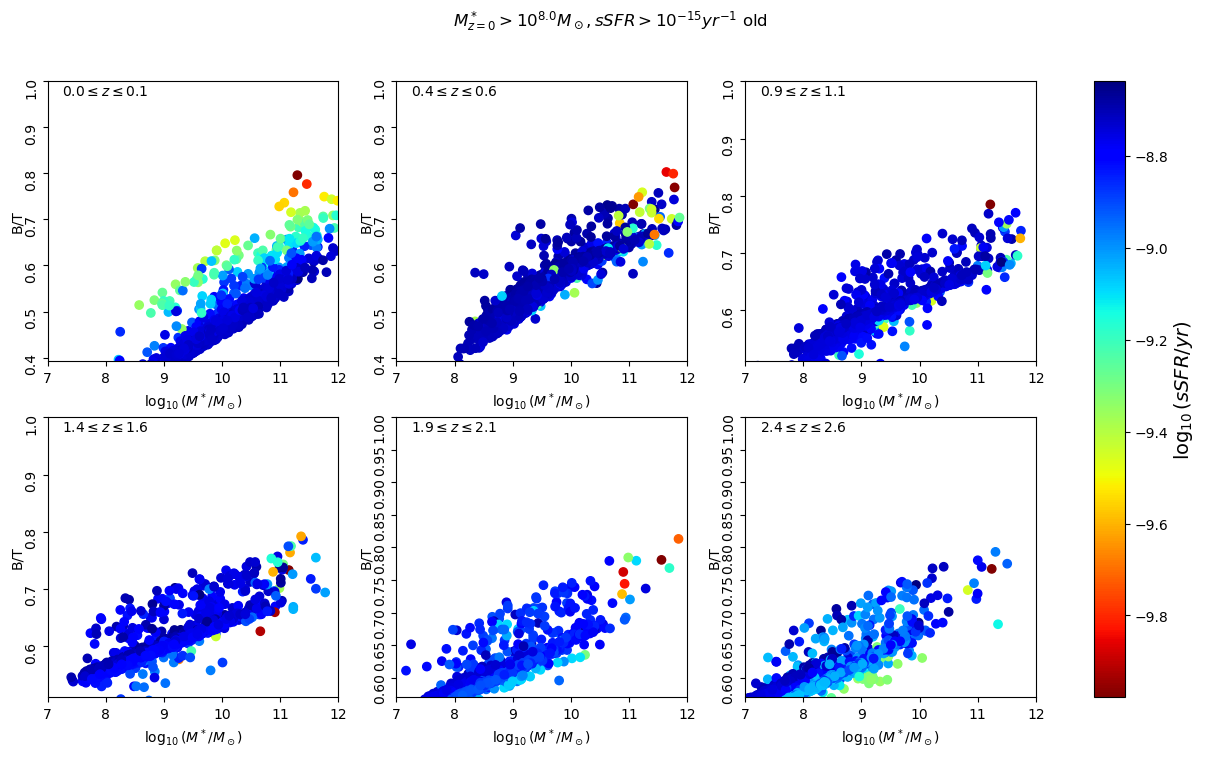

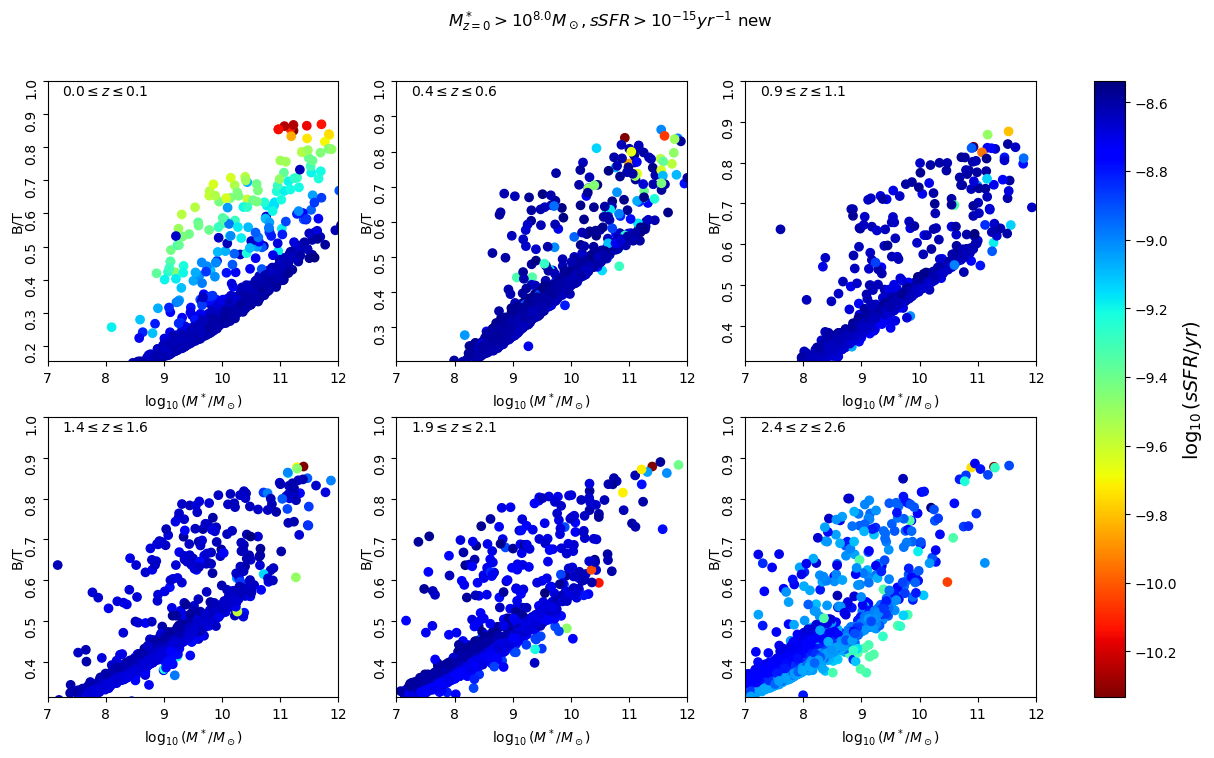

In [39]:
for diffstar, v in zip([diffstar_old, diffstar_new], ["old", "new"]):
    
    plot_q1_vs_q2(
        jnp.log10(diffstar["smh"][mask]),
        diffstar["bth"][mask],
        zvalues,
        redshifts,
        jnp.log10(diffstar["sSFR"][mask]),
        title=' '.join([title, v]),
        xname=xname + "_model_tweak_{}".format(v),
        cmap="jet_r",
        N=2000,
        ymin=0,
        ymax=1.0,
        xmin=7,
        xmax=12,
        xlabel="$\\log_{10}(M^*/M_\\odot)$",
        ylabel="B/T",
        cbar_title="$\\log_{10}(sSFR/yr)$",
        pltname="BoverT_vs_logMstar_{}.png",
        plotdir=plotdir,
        label_y=0.95,
)

In [40]:
qs =[diffstar_old['bth'][mask], diffstar_new['bth'][mask]]
xs = [diffstar_old['smh'][mask], diffstar_new['smh'][mask]]
cut_arrays = [jnp.log10(diffstar_old['sSFR'][mask]), jnp.log10(diffstar_new['sSFR'][mask])]
cuts = [-11, -10.5]
colors_list = (("orange", "cyan"), ("r", "blue"))

Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulge_Profiles/BT_cut_on_log_sSFR_comparison.png


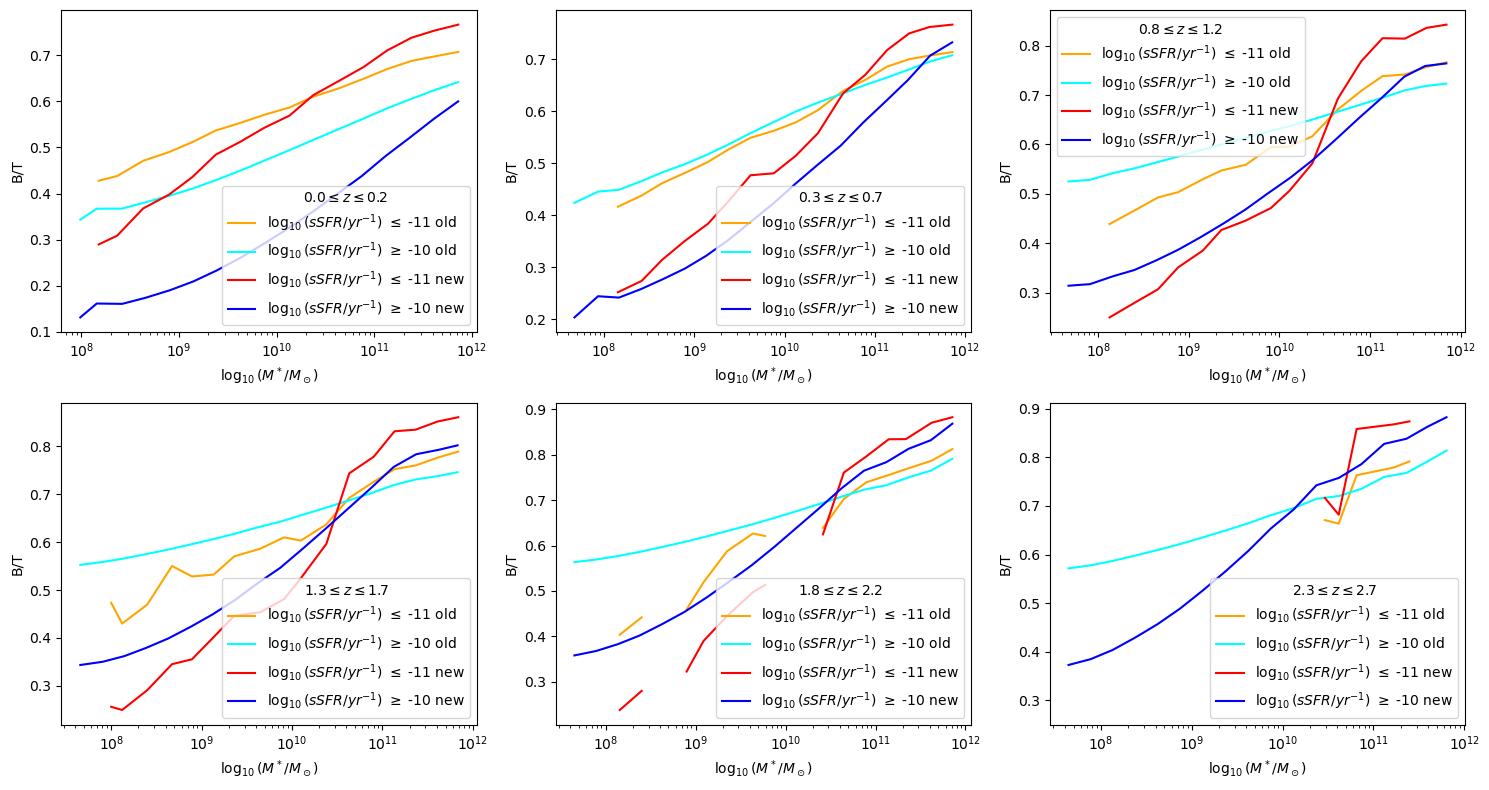

In [41]:
plot_qs_profiles_with_cuts(
    qs,
    xs,
    zvalues,
    redshifts,
    cut_arrays,
    cuts,
    slabels=['old', 'new'],
    dz=0.2,
    bin_lo=7.5,
    bin_hi=12.0,
    Nbins=18,
    cut_labels=("{{}} $\\leq$ {:.0f}", "{{}} $\\geq$ {:.0f}"),
    colors_list=colors_list,
    cut_name="$\\log_{10}(sSFR/yr^{-1})$",
    plotdir=plotdir,
    plotsubdir="DiskBulge_Profiles",
    pltname="BT_cut_on_{}_comparison.png",
    yscale="",
    xscale="log",
    xlabel="$\\log_{10}(M^*/M_\\odot)$",
    xname="log_sSFR",
    lgnd_title="",
    error=False,
    ylabel="B/T",
)